In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
from scipy import signal
from scipy.optimize import curve_fit
import subprocess
import shutil

pi = np.pi
clight = 299792458
E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
clight = 299792458

In [2]:
def func_exp_fit(x, a, b, c):
    return a*np.exp(b*x)+c

In [3]:
def get_folders(folders,cwd):
    new_folders = []
    for folder in folders:
        if os.path.isdir(os.path.join(cwd,folder)):
            print(folder)
            new_folders.append(folder)
    return new_folders

In [4]:
working_folder = ''
home0 = os.getcwd()
home1 = os.path.join(home0,working_folder)
cwd = os.path.join(home0,working_folder)


In [5]:
folders = os.listdir(cwd)
new_folders = get_folders(folders,cwd)
new_folders = np.sort(new_folders)

#get the starting index in the folder name string that represent the substring of current
i_start_current = new_folders[0].find('Idc')+3

#get the starting index in the folder name string that represent the substring of loading angle
i_start_thetaL = new_folders[0].find('ThetaL')+6

current = [float(folder[folder.find('Idc')+3:folder.find('Idc')+3+4]) for folder in new_folders]
thetaL = [float(folder[folder.find('ThetaL')+6:folder.find('ThetaL')+6+3]) for folder in new_folders]


In [9]:
inputfile = 'input.txt'
temppath = os.path.join(cwd,new_folders[0])
inputfile = os.path.join(temppath,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])


ValueError: could not convert string to float: 'bug'

In [10]:
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
nTurns = int(tempinput['n_turns'][0])
nDynamic = int(tempinput['n_dynamicOn'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
n_record = nTurns/step
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
t_rad_long = tempinput['t_rad_long'][0]
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print(bucket_height)
print(Ek)
print(Qs)


269.570327729
10015579420.0
0.0540982655071


debug
[  1.34671548e+00   5.45820263e-05  -1.25160520e+00]
[[  1.07371404e-01  -3.61810152e-06  -1.08675915e-01]
 [ -3.61810152e-06   1.22123803e-10   3.66081231e-06]
 [ -1.08675915e-01   3.66081231e-06   1.10007123e-01]]


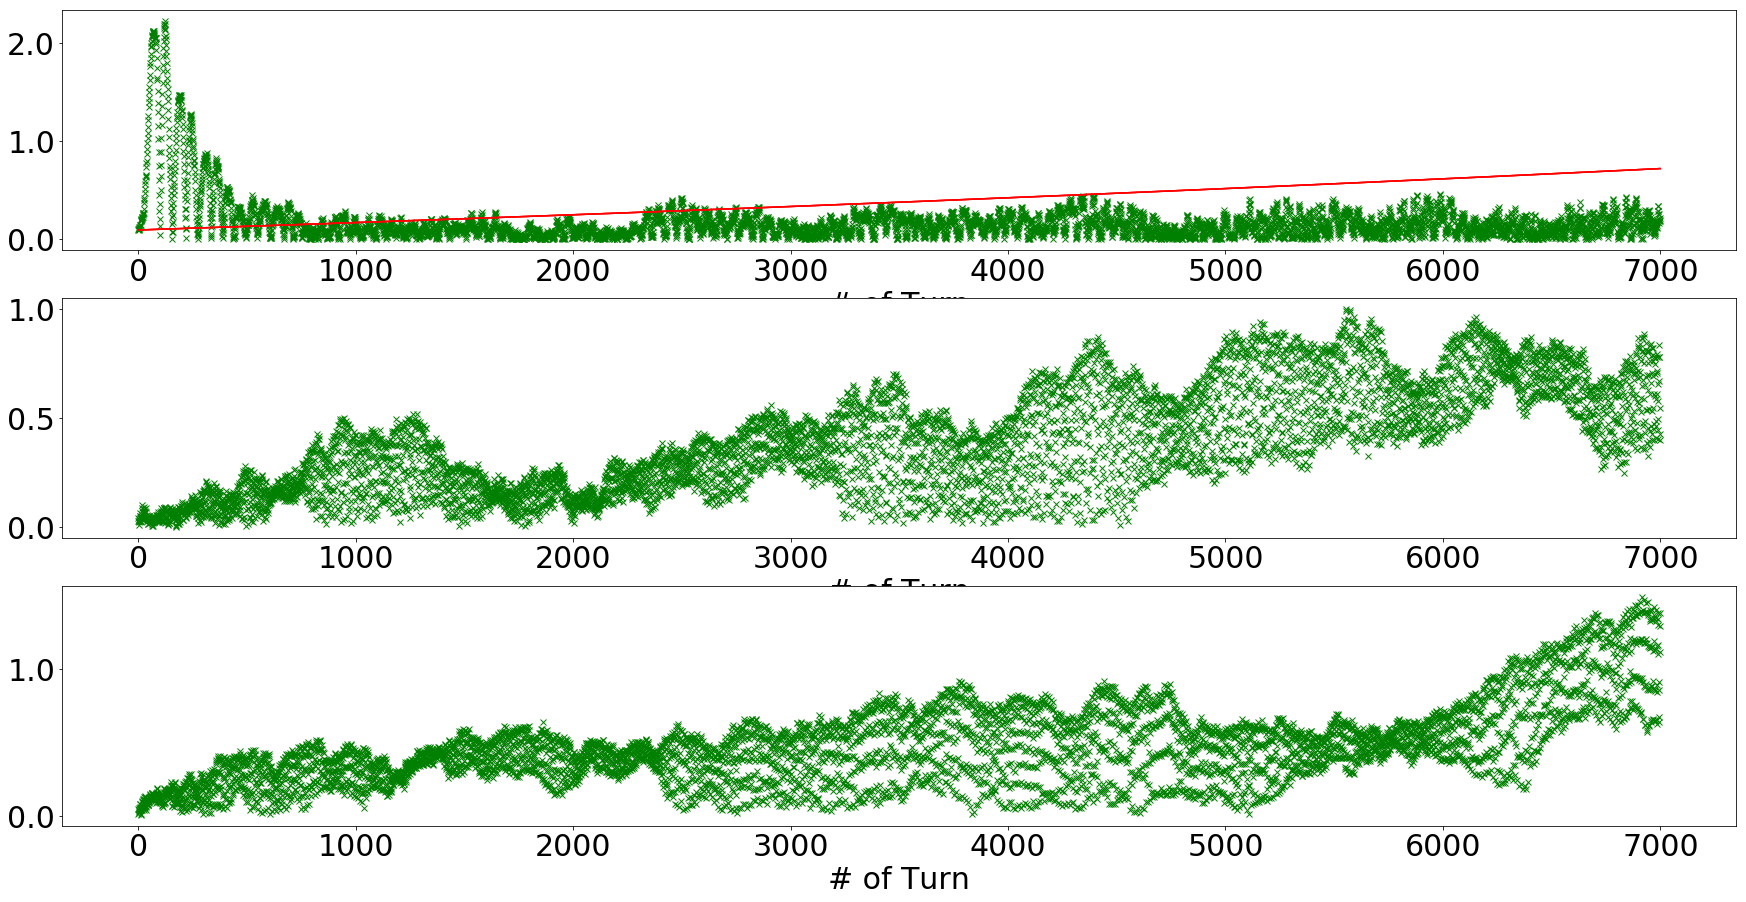

src


FileNotFoundError: [Errno 2] No such file or directory: '/home/txin/Dropbox/code/Cpp/APES_pack/APES8.3/src/input.txt'

In [11]:
# get the fitted growth rate
# first, find the turn number where the mu=1 mode amplitude exceed certain value
def get_the_turn_number(c,value):
    for i in range(len(c)):
        if c[i]>=value:
            return i
    return i

inputfn = 'input.txt'
datafn = 'data.bin'
N_mode = 3
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
qs = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
taus = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
q_guess = 0.01
qidx = 0
folders.sort()
for folder in new_folders:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    test = array('d')
    bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0


    
    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_1 = []
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_1.append(M1_all[i*nBunch*2+j])
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])

# calculate the components
    sincomp = []
    coscomp = []
    a = np.ndarray([N_mode,nTurns])
    b = np.ndarray([N_mode,nTurns])
    c = np.ndarray([N_mode,nTurns])
    
    value = 5 # the value where we stop the plotting
    idx = 0
    
    fig1,axes1 = plt.subplots(N_mode,1)
    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    
    for mu in range(N_mode):
        sincomp.append(np.sin(mu*2*pi*f0*np.array(centroids)))
        coscomp.append(np.cos(mu*2*pi*f0*np.array(centroids)))
        for i in range(nTurns):
            a[mu][i] = np.sum(sincomp[mu]*M1_2[i*nBunch:(i+1)*nBunch])/len(sincomp[mu])
            b[mu][i] = np.sum(coscomp[mu]*M1_2[i*nBunch:(i+1)*nBunch])/len(coscomp[mu])
        c[mu] = np.sqrt(np.array(a[mu])**2+np.array(b[mu])**2)
    idx = get_the_turn_number(c[1],value)
# fit the growth rate
    
    turn_temp = range(idx-nDynamic)
    cNew = c[1][nDynamic:idx]
    if qidx<=25:
        q_guess = 0.3
    else:
        q_guess = 0.3
    popt, pcov = curve_fit(func_exp_fit, turn_temp, \
                           cNew,bounds=([-cNew[0]*100,-q_guess,-cNew[0]*100], [cNew[0]*100, q_guess, cNew[0]*100]),\
                           maxfev=20000000)
    print(popt)
    print(pcov)
    qs[qidx] = popt[1]
    qidx+=1
    c_fit =  popt[0]*np.exp(popt[1]*turn_temp)+popt[2]
    for mu in range(N_mode):
        axes1[mu].plot(c[mu][nDynamic:idx],'gx')
        axes1[0].plot(c_fit,'r-')
        #axes1[1].legend(["growth_rate = "+str(qs[qidx])])
        axes1[mu].tick_params(labelsize=50)

        axes1[mu].set_xlabel('# of Turn',fontsize=30)

        axes1[mu].tick_params(labelsize=30)
        y_labels = axes1[mu].get_yticks()
        axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    fn_after = os.path.join(cwd,'CB_Modes.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
axes1.plot(current,qs,'rx-')
plt.show()
#taus = T0/qs

In [ ]:
os.chdir(home0)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(thetaL,qs,'rx')

axes1.set_ylabel('Im(OMEGA)',fontsize=30)
axes1.set_xlabel('ThetaL [degree]',fontsize=30)
axes1.legend(["Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
T0/qs[-1]*1000

In [ ]:
qs

In [ ]:
os.chdir(home0)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(current,qs,'rx-')
axes1.set_xlabel('IbDC [A]',fontsize=30)

axes1.set_ylabel('Im(OMEGA)',fontsize=30)
axes1.set_xlabel('IbDC [A]',fontsize=30)
axes1.legend(["Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# get analitical number from simple formula (Chao's book)
def Zparallel(Rsh, QL, omega0, omega):
    return Rsh*omega/(omega+1j*QL*(omega0-omega**2/omega0)) # using the convention from A. Chao's book
# Small tune shift approximation
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = 1*nBunch # number of samples in frequency domain

#only look at the mu=? mode
mu = -1
delta_omega_Re = np.zeros(len(new_folders))
delta_omega_Im = np.zeros(len(new_folders))
ps = np.array([float(i) for i in range(-pmax,pmax)])

p_M_omega0 = ps*nBunch*2*np.pi*f0

omegas = Qs*2*pi*f0
qidx=0

for folder in new_folders[:]:
    #print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    
    # for the calculation of real part of Omega

    omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas) # using incoherent omegas for approximation
    Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas) # using incoherent omegas for approximation
    deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))
    # for the calculation of the imaginary part of Omega
    omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

    factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

    Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
    deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
    delta_omega_Re[qidx] = deltaOmegaRe
    delta_omega_Im[qidx] = deltaOmegaIm
    print(deltaOmegaRe/2/pi,deltaOmegaIm)
    qidx+=1
os.chdir(home0)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(current,delta_omega_Im*T0,'rx-')
axes1.set_ylabel('Im(OMEGA)',fontsize=30)
axes1.set_xlabel('IbDC [A]',fontsize=30)
axes1.legend(["Analytical(Chao)","Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))
fn_growth_rate = os.path.join(cwd,'growth_rate_analytical.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(thetaL,delta_omega_Im*T0,'rx')
axes1.set_ylabel('Im(OMEGA)',fontsize=30)
axes1.set_xlabel('ThetaL [degree]',fontsize=30)
axes1.legend(["Analytical(Chao)","Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_analytical_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# iterative solver
def F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0):
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R[i],QL[i],omegac[i],omegasamp) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
    return Omega**2-(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)

def SolveOmega(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu):
    nIter = 0
    # initial values
    OmegaR = np.real(Omega)
    OmegaI = np.imag(Omega)
    # step size
    sig1 = 1
    sig2 = 1*1j
    Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
    
    while(np.abs(Err)>accu and nIter<maxIter):
        OmegaR = np.real(Omega)
        OmegaI = np.imag(Omega)
        Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
        F1 = F(Omega+sig1,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaRe by a small step
        F2 = F(Omega+sig2,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaIm by a small step
        Fre = np.real(Err)
        Fim = np.imag(Err)
        F1re = np.real(F1)
        F1im = np.imag(F1)
        F2re = np.real(F2)
        F2im = np.imag(F2)
        # approximate the Jacobian
        dF11 = F1re-Fre
        dF12 = F2re-Fre
        dF21 = F1im-Fim
        dF22 = F2im-Fim
        
        det = dF11*dF22-dF12*dF21
        # inverse the Jacobian
        dF11inv = dF22/det
        dF12inv = -dF12/det
        dF21inv = -dF21/det
        dF22inv = dF11/det

        OmegaR -= Fre*dF11inv+Fim*dF12inv
        OmegaI -= Fre*dF21inv+Fim*dF22inv
        Omega = OmegaR+OmegaI*1j
        nIter += 1
    return Omega
    print(Omega)
    print(np.abs(Err))
    print(nIter)

In [ ]:
# Iteratively solve:
qidx=0
delta_omega_Re_Iter = np.zeros(len(new_folders))
delta_omega_Im_Iter = np.zeros(len(new_folders))
mus = [-1]#[nBunch-1]
OMEAG_ini = [omegas*np.exp(1j*i/100*2*pi) for i in range(100)]
for folder in new_folders[:]:
    #print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    test = array('d')
    for i in mus:
        maxOMEGAIM = -1e360
        for Omega in OMEAG_ini:
            temp = SolveOmega(Omega,ps,i,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,200,1e-9)
            if np.imag(temp)>maxOMEGAIM:
                maxOMEGAIM = np.imag(temp)
                delta_omega_Re_Iter[qidx] = np.real(temp)
                delta_omega_Im_Iter[qidx] = np.imag(temp)
        print(qidx,';',delta_omega_Re_Iter[qidx]-omegas,delta_omega_Im_Iter[qidx])
    qidx+=1


In [ ]:
os.chdir(home0)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(thetaL,delta_omega_Im*T0,'rx', ms = 20)
axes1.plot(thetaL,delta_omega_Im_Iter*T0,'b*', ms = 20)
#axes1.plot(thetaL,qs,'g.', ms = 20)

axes1.set_title('Growth Rate (Q_IM) of mu = -1 mode',fontsize=30)
axes1.set_ylabel('Im(Q)',fontsize=30)
axes1.set_xlabel('ThetaL [degree]',fontsize=30)
axes1.legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.9f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
os.chdir(home0)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(thetaL,1/delta_omega_Im*1000,'rx', ms = 20)
axes1.plot(thetaL,1/delta_omega_Im_Iter*1000,'b*', ms = 20)
#axes1.plot(thetaL,qs,'g.', ms = 20)

axes1.set_title('Growth time of mu = -1 mode',fontsize=30)
axes1.set_ylabel('tau [ms]',fontsize=30)
axes1.set_xlabel('ThetaL [degree]',fontsize=30)
axes1.legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.9f'))

fn_growth_rate = os.path.join(cwd,'growth_time_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
os.chdir(home0)
cwd = os.getcwd()
#current = [float(folder[21:25]) for folder in folders]
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(current,delta_omega_Im*T0,'rx-')
axes1.plot(current,delta_omega_Im_Iter*T0,'b*-')
#axes1.plot(current,qs,'g.-', ms = 20)

axes1.set_title('Growth Rate (Q_IM) of mu = -1 mode',fontsize=30)
axes1.set_ylabel('Im(Q)',fontsize=30)
axes1.set_xlabel('IbDC [A]',fontsize=30)
axes1.legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.9f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
os.chdir(home0)
cwd = os.getcwd()
#current = [float(folder[21:25]) for folder in folders]
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
rng1 = 0
rng2 = 50
axes1.plot(thetaL[rng1:rng2],delta_omega_Im[rng1:rng2]*T0-T0/t_rad_long,'rx')
axes1.plot(thetaL[rng1:rng2],qs[rng1:rng2],'g.', ms = 20)
axes1.plot(thetaL[rng1:rng2],delta_omega_Im_Iter[rng1:rng2]*T0-T0/t_rad_long,'b*')
axes1.axhline(y=0)

axes1.set_title("Growth Rate (Q_IM) of mu = "+str(mus[0])+" mode",fontsize=30)
axes1.set_ylabel('Im(Q)',fontsize=30)
axes1.set_xlabel('ThetaL [degree]',fontsize=30)
axes1.legend(["Analytical(Chao)","Fitted from simulation", "Iterative_Solver"],prop={'size': 30})
axes1.tick_params(labelsize=30)
#axes1.set_ylim([-0.001,0.001])
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
os.chdir(home0)
cwd = os.getcwd()
#current = [float(folder[21:25]) for folder in folders]
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
rng1 = 0
rng2 = 50
axes1.plot(current[rng1:rng2],delta_omega_Im[rng1:rng2]*T0-T0/t_rad_long,'rx-')
axes1.plot(current[rng1:rng2],qs[rng1:rng2],'g.-', ms = 20)
axes1.plot(current[rng1:rng2],delta_omega_Im_Iter[rng1:rng2]*T0-T0/t_rad_long,'b*-')
axes1.axhline(y=0)

axes1.set_title('Growth Rate (Q_IM) of mu = -1 mode',fontsize=30)
axes1.set_ylabel('Im(Q)',fontsize=30)
axes1.set_xlabel('IbDC [A]',fontsize=30)
axes1.legend(["Analytical(Chao)","Fitted from simulation", "Iterative_Solver"],prop={'size': 30})
axes1.tick_params(labelsize=30)
#axes1.set_ylim([-0.001,0.001])
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
"{0:02d}".format(-1)

In [ ]:
M1_all = array('d')
M1_fn = 'M1_all.bin'
datafile = os.path.join(cwd,'eSR','2RF','Allow_thetaL',new_folders[0],M1_fn)    

with open(datafile, mode='rb') as file: # b is important -> binary
    M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
M1_1 = []
M1_2 = []
for i in range(nTurns):
    for j in range(nBunch):
        M1_1.append(M1_all[i*nBunch*2+j])
        M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
turns = np.array([i for i in range(nTurns*nBeam*nBunch)])

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
a = 9999
b = 1
axes1.plot(M1_2[a*nBunch:(a+b)*nBunch],'rx-')

axes1.axvline(x=0)

axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

plt.show()

In [ ]:
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
rng1 = 0
rng2 = 50
axes1.plot(ps,np.real(Zs2[0]),'rx-')
axes1.plot(ps,np.real(Zs2[1]),'gx-')

axes1.axvline(x=0)

axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

plt.show()

In [ ]:
# M2
inputfn = 'input.txt'
datafn = 'data.bin'
N_mode = 3
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
qs = np.zeros(len(folders)) # to calculate the growth rate of mu=1
taus = np.zeros(len(folders)) # to calculate the growth rate of mu=1
q_guess = 0.01
qidx = 0
folders.sort()
for folder in new_folders[:]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    test = array('d')
    bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

    
    M2_all = array('d')
    M2_fn = 'M2_all.bin'
    datafile = os.path.join(cwd,M2_fn)
    print(datafile)
    with open(datafile, mode='rb') as file: # b is important -> binary
        M2_all.fromfile(file,3*nTurns*nBeam*nBunch)
    M2_1 = []
    M2_2 = []
    M2_3 = []

    for i in range(nTurns):
        for j in range(nBunch):
            M2_1.append(M2_all[i*nBunch*3+j])
            M2_2.append(M2_all[i*nBunch*3+nBunch+j]-Gamma0)
            M2_1.append(M2_all[i*nBunch*3+nBunch*2+j])
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    
    nTurn_start = 5000
    nTurn_disp = 1
    axes1.plot(M2_1[nTurn_start*nBunch:(nTurn_start+nTurn_disp)*nBunch],'rx-')
    axes1.axhline(y=0)
    axes1.tick_params(labelsize=30)
    #axes1.set_ylim([-0.001,0.001])
    y_labels = axes1.get_yticks()
    axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.15f'))
    plt.show()

In [ ]:
cwd

In [ ]:
inputfn = 'input.txt'
datafn = 'data.bin'
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
for folder in folders[:]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    test = array('d')
    bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

    datafile = os.path.join(cwd,datafn)
    with open(datafile, mode='rb') as file: # b is important -> binary
        test.fromfile(file,int((n_stride)*nTurns/step*NpRF*h[0]))

    time = np.array(test[0::n_stride])
    Ibi = np.array(test[1::n_stride])
    #Ibi_1 = np.array(test[2::n_stride])
    Ibi2 = np.array(test[3::n_stride])

    V = []
    Ig = []
    #U = []
    Vref = []
    Iref = []
    Power = []
    for i in range(nRF):
        V.append(np.array(test[1+2*nBeam+0+i*3::n_stride]))
        Ig.append(np.array(test[1+2*nBeam+1+i*3::n_stride]))
        #U.append(np.array(test[1+2*nBeam+2+i*3::n_stride]))
        print(V0[i],V0Q[i])
        Vref.append(V0[i]*np.sin(omegarf[i]*time)+V0Q[i]*np.cos(omegarf[i]*time))
        Iref.append(II[i]*np.sin(omegarf[i]*time)+IQ[i]*np.cos(omegarf[i]*time))
        Power.append(V[i]*Ig[i])

    datafilepar = 'first.bin'
    datafilepar = os.path.join(cwd,datafilepar)
    with open(datafilepar, mode='rb') as file: # b is important -> binary
        fileContent = file.read()
    datapar = np.array([struct.unpack('dd',fileContent[i*16:(i+1)*16]) for i in range(int(len(fileContent)/16))]).T
    first_dt = np.array(datapar[0])
    first_gamma = np.array(datapar[1])

    rng1 =  0
    rng2 = int(nTurns-1)

    step1 = 1

    fig1,axes1 = plt.subplots(1,1)

    axes1.plot(first_gamma[rng1:rng2:step1]-Gamma0,'rx-',ms=1)

    axes1.set_xlabel('# of Turn',fontsize=30)
    axes1.set_ylabel('Delta Gamma (first bunch)',fontsize=30)
    axes1.tick_params(labelsize=30)
    y_labels = axes1.get_yticks()
    axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    fn_Bench = os.path.join(cwd,'Delta_gamma_first_bunch.jpg')
    plt.savefig(fn_Bench,bbox_inches='tight')
    plt.show()


    
    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_1 = []
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_1.append(M1_all[i*nBunch*2+j])
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])
    turn_display = 7500
    rng1 =  turn_display*nBeam*nBunch
    rng2= rng1+nBunch*1
    rng3= rng2+5#nBunch*1
    fig1,axes1 = plt.subplots(1,1)
    axes1.plot(turns[rng1:rng2],np.array(M1_2[rng1:rng2]),'r.-')
    axes1.plot(turns[rng2:rng3],np.array(M1_2[rng2:rng3]),'gx-')

    fig1.set_figheight(15)
    fig1.set_figwidth(30)

    axes1.set_xlabel('bunch #',fontsize=30)
    axes1.set_ylabel('Gamma_Centroid',fontsize=30)
    axes1.tick_params(labelsize=30)
    y_labels = axes1.get_yticks()
    axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))
    #fn_Ipeak = os.path.join(cwd,'Ipeak.jpg')
    #plt.savefig(fn_Ipeak,bbox_inches='tight')
    plt.show()
    sin0 = np.sin(0*2*pi*f0*np.array(centroids))
    cos0 = np.cos(0*2*pi*f0*np.array(centroids))
    sin1 = np.sin(1*2*pi*f0*np.array(centroids))
    cos1 = np.cos(1*2*pi*f0*np.array(centroids))
    a0 = []
    b0 = []
    c0 = []
    a1 = []
    b1 = []
    c1 = []
    for i in range(nTurns):
        a0.append(np.sum(sin0*M1_2[i*nBunch:(i+1)*nBunch])/len(sin0))
        b0.append(np.sum(cos0*M1_2[i*nBunch:(i+1)*nBunch])/len(sin0))
        a1.append(np.sum(sin1*M1_2[i*nBunch:(i+1)*nBunch])/len(sin1))
        b1.append(np.sum(cos1*M1_2[i*nBunch:(i+1)*nBunch])/len(sin1))
    c0 = np.array(a0)**2+np.array(b0)**2
    c1 = np.array(a1)**2+np.array(b1)**2
    
    fig1,axes1 = plt.subplots(2,1)
    axes1[0].plot(np.sqrt(c0))
    axes1[1].plot(np.sqrt(c1))
    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    axes1[0].tick_params(labelsize=50)

    axes1[0].set_xlabel('# of Turn',fontsize=30)
   
    axes1[0].tick_params(labelsize=30)
    y_labels = axes1[0].get_yticks()
    axes1[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    fn_after = os.path.join(cwd,'CB_Modes.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
    

backup zone

In [ ]:
# Power
Power_average1 = 0.5*np.array([np.mean(Power[0][i*h[0]*NpRF:(i+1)*h[0]*NpRF]) for i in range(int(n_record))])
Power_average = Power_average1#+Power_average2
fig1,axes1 = plt.subplots(1,1)
axes1.plot(Power_average/1e6)
axes1.axhline(y = Pbeam/1e6)
fig1.set_figheight(30)
fig1.set_figwidth(30)

plt.show()
os.chdir(home1)
# VI

startTurn =int(nTurns/step-1)
startRF = 0 
nRFsamp = 1

rng1 = NpRF*(h[0]*startTurn+startRF)+int(3*NpRF/8)*0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(3*NpRF/8)*0
step1 = 1
step2 = 1

if nRF>1:
    fig1,axes1 = plt.subplots(4,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V[i][rng1:rng2:step1],'r.-',ms=10)
        axes1[0][i].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0][i].axhline(y=0)
        axes1[0][0].axhline(y=3.7e6/14*8)
        axes1[0][1].axhline(y=3.7e6/14*6)
        axes1[0][0].axhline(y=Vnew*NF)
        axes1[0][1].axhline(y=Vnew*ND)
        axes1[0][i].axvline(x=int(NpRF/2))
        axes1[1][i].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        if nBeam == 2 :
            axes1[1][i].plot(Ibi2[rng1:rng2:step1],'g.-',ms=10)
        axes1[2][i].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2][i].set_ylim([-3e4,3e4])
        axes1[2][i].axvline(x=int(NpRF/2))
        axes1[3][i].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3][i].plot((Iref[i])[rng1:rng2:step1],'g-',ms=10)
        #axes1[3][i].plot((Iref[i]-Ig[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].axvline(x=int(NpRF/2))
        #axes1[0][i].set_ylim([-3e6,3e6])
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V[i][rng1:rng2:step1],'rx-',ms=10)
        axes1[0].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0].axhline(y=0)
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axvline(x=int(NpRF/2))
        #axes1[0].set_ylim([3.0e6,4e6])
        axes1[1].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        axes1[1].axvline(x=int(NpRF/2))
        axes1[2].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2].set_ylim([-4e4,4e4])
        axes1[2].axhline(y=0)
        axes1[3].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3].plot((Iref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[3].axhline(y=0)
        axes1[3].axvline(x=int(NpRF/2))
fig1.set_figheight(30)
fig1.set_figwidth(30)

fn_VI = os.path.join(cwd,'VI'+str(startTurn*step)+'.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()
#V_frq

datafile = 'f_cav.bin'
datafile = os.path.join(cwd,datafile)
pattern = nRF*'d'
stride = len(pattern)*8
with open(datafile, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
data = np.array([struct.unpack(pattern,fileContent[i*stride:(i+1)*stride]) for i in range(int(len(fileContent)/stride))]).T
frqs = []
for i in range(nRF):
    frqs.append(np.array(data[i])/2/np.pi)
V_max = []
Ig_max = []
for i in range(nRF):
    V_max.append([])
    Ig_max.append([])
    for j in range(int(len(V[i])/NpRF/h[0])-1):
        V_max[i].append(np.max(V[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
        #Ig_max[i].append(np.max(Ig[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
start = 0 # this number times n_per_step gives real turn number 
end = int(nTurns/step)
if nRF>1:
    fig1,axes1 = plt.subplots(2,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V_max[i][start:end],'r.-',ms=10)
        #axes1[0][i].set_yscale('log')
        axes1[1][i].axhline(y = h[i])
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])+1)
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])-1)
        #axes1[2][i].plot(Ig_max[i][start:end],'r.-',ms=10)
        axes1[1][i].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)        
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V_max[i][start:end],'r.-',ms=10)
        axes1[1].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)   
        #axes1[1].axhline(y = omegarf[i]/(omegarf[0]/h[0]))

fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'process.jpg')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

datafilepar = 'init.bin'
datafilepar = os.path.join(cwd,datafilepar)
pat = nTot*'d'
strd = nTot*8
with open(datafilepar, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
datapar = np.array([struct.unpack(pat,fileContent[i*strd:(i+1)*strd]) for i in range(int(len(fileContent)/strd))])
dt_init = np.array(datapar[0])
gamma_init = np.array(datapar[1])

rng1 =  0*nPar
rng2 = int(1*nPar)
step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(dt_init[rng1:rng2:step1],gamma_init[rng1:rng2:step1]-Gamma0,'r.',ms=10)

bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]
#for bins in bin_centers:
#axes1.axvline(x = bin_centers[17])
#axes1.axvline(x = bin_centers[15])
#axes1.axvline(x = bin_centers[32])
#axes1.axvline(x = bin_centers[31])
#axes1.axvline(x = bin_centers[16])
#axes1.axvline(x = bin_centers[16]+7.7e-10)
#axes1.axvline(x = bin_centers[16]-7.7e-10)
#axes1.axhline(y = 107.35+0.05)
#axes1.axhline(y = 107.35-0.05)
#axes1.set_xlim([bin_centers[0],bin_centers[-1]])
axes1.set_xlabel('dt',fontsize=30)
axes1.set_ylabel('dGamma',fontsize=30)
fig1.set_figheight(15)
fig1.set_figwidth(30)
plt.show()

dt1 = dt_init[rng1:rng2:step1]
delta1 = gamma_init[rng1:rng2:step1]#*(197*931.5e6) # convert into eV
sig_dt1_sqr = np.sum((dt1-np.sum(dt1)/len(dt1))**2)/len(dt1)
sig_delta1_sqr = np.sum((delta1-np.sum(delta1)/len(delta1))**2)/len(delta1)
sig_dt1_delta1 = np.sum((delta1-np.sum(delta1)/len(delta1))*(dt1-np.sum(dt1)/len(dt1)))/len(delta1)
emittance = np.sqrt(sig_dt1_sqr*sig_delta1_sqr-sig_dt1_delta1**2)*np.pi*(197*931.5e6)
print(sig_dt1_sqr**0.5)
print(sig_delta1_sqr**0.5)
print(emittance*6/197)

datafilepar = 'par.bin'
datafilepar = os.path.join(cwd,datafilepar)
nData = int(nTurns/step)
par_store_tot = nTot*nData
pat = nTot*'d'*2
strd = nTot*8*2
datapar = array('d')

with open(datafilepar, mode='rb') as file: # b is important -> binary
    datapar.fromfile(file,par_store_tot*2)

dt = np.zeros(par_store_tot)
gamma = np.zeros(par_store_tot)
for i in range(nData):
    dt[i*nPar*nBunch*nBeam:(i+1)*nPar*nBunch*nBeam] = datapar[i*nBeam*nPar*nBunch*2:(i*2+1)*nPar*nBunch*nBeam]
    gamma[i*nPar*nBunch*nBeam:(i+1)*nPar*nBunch*nBeam] = datapar[(i*2+1)*nBeam*nPar*nBunch:(i*2+2)*nPar*nBunch*nBeam]
    #dt.append(datapar[i*2*nPar*nBunch*2:(i*2+1)*nPar*nBunch*2])
    #gamma.append(datapar[(i*2+1)*nPar*nBunch*2:(i*2+2)*nPar*nBunch*2])

turn_display = int(nTurns/step-1)
bunch_display = 0
nBunch_display = 1
rng11 =  turn_display*nBunch*nBeam*nPar+(bunch_display)*nPar
rng21= turn_display*nBunch*nBeam*nPar+(bunch_display+nBunch_display)*nPar

rng1 = (bunch_display)*nPar
rng2 = (bunch_display+nBunch_display)*nPar
step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(dt_init[rng1:rng2:step1],gamma_init[rng1:rng2:step1]-Gamma0,'rx',ms=15)
axes1.plot(dt[rng11:rng21:],gamma[rng11:rng21:]-Gamma0,'g.',ms=15)

bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]
#for bins in bin_centers:
#axes1.axvline(x = bin_centers[17])
#axes1.axvline(x = bin_centers[15])
#axes1.axvline(x = bin_centers[32])
#axes1.axvline(x = bin_centers[31])
#axes1.axvline(x = bin_centers[32]+3*Trf[0])
#axes1.axvline(x = bin_centers[32]+7.7e-10+3*Trf[0])
#axes1.axvline(x = bin_centers[32]-7.7e-10+3*Trf[0])
#axes1.axhline(y = 107.35+0.05)
#axes1.axhline(y = 107.35-0.05)
#axes1.set_xlim([bin_centers[0]-bunch_display/(f0*h[0])*6,bin_centers[NpRF-1]+bunch_display/(f0*h[0])*6])
axes1.set_xlim([bin_centers[0]+bunch_display*3*Trf[0],bin_centers[NpRF-1]+bunch_display*3*Trf[0]])

axes1.set_xlabel('dt',fontsize=30)
axes1.set_ylabel('dGamma',fontsize=30)
fig1.set_figheight(15)
fig1.set_figwidth(30)
plt.show()

def get_bucket_limits(bucket_lower_lim,bucket_upper_lim,beam_shift,Trf,Trev,nParPerData,nParPerTurn,nPar):
    bucket_lower_lim = np.mod(((np.mod(np.mod(bucket_lower_lim,nParPerData),nParPerTurn)/nPar).astype(int)*fill_step+(np.mod(bucket_lower_lim,nParPerData)/nParPerTurn).astype(int)*(beam_shift+0.25))*Trf,Trev)
    bucket_upper_lim = np.mod(((np.mod(np.mod(bucket_upper_lim,nParPerData),nParPerTurn)/nPar).astype(int)*fill_step+(np.mod(bucket_upper_lim,nParPerData)/nParPerTurn).astype(int)*(beam_shift+0.25)+1)*Trf,Trev)
    #bucket_lower_lim = (((bucket_lower_lim%(nParPerData))%(nParPerTurn)/nPar).astype(int)*3+((bucket_lower_lim%(nParPerData))/(nParPerTurn)).astype(int)*(beam_shift+0.5))*Trf
    #bucket_upper_lim = (((bucket_upper_lim%(nParPerData))%(nParPerTurn)/nPar).astype(int)*3+((bucket_upper_lim%(nParPerData))/(nParPerTurn)).astype(int)*(beam_shift+0.5)+1)*Trf
    return bucket_lower_lim,bucket_upper_lim
def get_mask(bucket_lower_lim, bucket_upper_lim,dt,mask):
    mask = np.abs((np.sign((dt-bucket_lower_lim)*(dt-bucket_upper_lim))-1)/2).astype(bool)
    return mask

bucket_lower_lim3 = np.arange(start=0, stop=len(dt))
bucket_upper_lim3 = np.arange(start=0, stop=len(dt))
mask = np.ones(len(dt))
bucket_lower_lim3,bucket_upper_lim3 = get_bucket_limits(bucket_lower_lim3,bucket_upper_lim3,beam_shift,Trf[0],T0,nBeam*nBunch*nPar,nBunch*nPar,nPar)

mask = get_mask(bucket_lower_lim3, bucket_upper_lim3,dt,mask)

dt_mask = dt*mask
gamma_mask = gamma*mask

t_0 = np.zeros(nData*nBeam*nBunch)
gamma_0 = np.zeros(nData*nBeam*nBunch)
nPar_mask = np.zeros(nData*nBeam*nBunch)
sig_t = np.zeros(nData*nBeam*nBunch)
sig_gamma = np.zeros(nData*nBeam*nBunch)
sig_t_gamma = np.zeros(nData*nBeam*nBunch)
emittance = np.zeros(nData*nBeam*nBunch)

for i in range(nData*nBeam*nBunch):
    nPar_mask[i] = np.sum(mask[i*nPar:(i+1)*nPar])
for i in range(nData*nBeam*nBunch):
    t_0[i] = np.sum(dt_mask[i*nPar:(i+1)*nPar])/nPar_mask[i]
    gamma_0[i] = (np.sum(gamma_mask[i*nPar:(i+1)*nPar]))/nPar_mask[i]

for i in range(nData*nBeam*nBunch):
    sig_t[i] = np.sum(((dt_mask[i*nPar:(i+1)*nPar]-t_0[i])*mask[i*nPar:(i+1)*nPar])**2)/nPar_mask[i]
    sig_gamma[i] = np.sum(((gamma_mask[i*nPar:(i+1)*nPar]-gamma_0[i])*mask[i*nPar:(i+1)*nPar])**2)/nPar_mask[i]
    sig_t_gamma[i] = np.sum((dt_mask[i*nPar:(i+1)*nPar]-t_0[i])*(gamma_mask[i*nPar:(i+1)*nPar]-gamma_0[i])*mask[i*nPar:(i+1)*nPar])/nPar_mask[i]
    #emittance[i] = np.sqrt(sig_t[i]*sig_gamma[i]-sig_t_gamma[i]**2)*np.pi*(197*931.5e6)*6/197
    emittance[i] = np.sqrt(sig_t[i]*sig_gamma[i]-sig_t_gamma[i]**2)*np.pi*(0.511e6)*6 # for electron
# plot average gamma along the train.
turn_display = int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(gamma_0[rng1:rng2:]-Gamma0,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('Delta Gamma',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

# plot average arriving time of the centroid along the train.
turn_display = int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
fig1,axes1 = plt.subplots(1,1)

axes1.plot((t_0[rng1:rng2:]-centroids)/Trf[0]*360,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('dphi along train',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

# plot average distance shift of the centroid along the train.
turn_display = int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
fig1,axes1 = plt.subplots(1,1)

axes1.plot((t_0[rng1:rng2:]-centroids)*clight*100,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('longitudianl shift along train (cm)',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train_dist.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()


# emittance plot
turn_display = 0
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*200

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.plot(emittance[rng1:rng2:],'rx-')
axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('Emittance',fontsize=30)
fn_emittance = os.path.join(cwd,'Emittance.jpg')
plt.savefig(fn_emittance,bbox_inches='tight')
plt.show()

# bunch length plot
turn_display = 0
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*200

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.plot(sig_t[rng1:rng2:]*clight,'rx-')
axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('sig_t',fontsize=30)
fn_length = os.path.join(cwd,'length.jpg')
plt.savefig(fn_length,bbox_inches='tight')
plt.show()
# particle loss
turn_display = 0
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*200

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]

axes1.plot(nPar_mask[rng1:rng2:],'rx')
axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('# Par',fontsize=30)
plt.show()

# I peak
I_peak = np.zeros(nData)
for i in range(nData):
    I_peak[i] = np.max(Ibi[i*NpRF*h[0]:(i+1)*NpRF*h[0]])

fig1,axes1 = plt.subplots(1,1)
axes1.plot(I_peak,'rx-')

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.set_xlabel('# of Turn [X'+str(step)+']',fontsize=30)
axes1.set_ylabel('I_peak',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
fn_Ipeak = os.path.join(cwd,'Ipeak.jpg')
plt.savefig(fn_Ipeak,bbox_inches='tight')
plt.show()

    def Zparallel(Rsh, QL, omega0, omega):
        return Rsh/(1+1j*QL*(omega/omega0-omega0/omega))

    #r0 = (79*1.6e-19)**2/(197*1.7e-27*3e8*3e8) # gold
    #r0 = (1*1.6e-19)**2/(1*1.7e-27*3e8*3e8) # Proton
    r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

    pmax = nBunch # number of samples 
    mu = 1#h[mainRF]%nBunch # 

    ps = np.array([float(i) for i in range(-pmax,pmax)])
    ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python

    # for the calculation of real part of Omega
    p_M_omega0 = ps*nBunch*2*np.pi*f0
    Zs0 = np.array([Zparallel(R[i],QL[i],omegac[i],p_M_omega0) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
    delta_omegas = factor1*np.sum(p_M_omega0*np.imag(Zs0))
    omegas = Qs*2*pi*f0+delta_omegas

    omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
    Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas)
    deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))

    # for the calculation of the imaginary part of Omega
    omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

    factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

    Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
    deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
    print(deltaOmegaRe)
    print(deltaOmegaIm)

    # Fitted
    def func_exp_fit(x, a, b, c):
        return a*np.exp(b*x)+c
    if 0:
        startTurn = 0
        endTurn = 1000
        delta_gamma_env = np.zeros(int((endTurn-startTurn)*Qs))
        TTurns = int(1/Qs) # numbers of turns per synchrotron oscillation
        delta_gamma_turn = np.array([i*TTurns+startTurn for i in range(len(delta_gamma_env))])
        delta_gamma_time = delta_gamma_turn*T0
        for i in range(len(delta_gamma_env)):
            delta_gamma_env[i] = np.max(first_gamma[i*TTurns+startTurn:(i+1)*TTurns+startTurn])-Gamma0
        popt, pcov = curve_fit(func_exp_fit, delta_gamma_time, \
                               delta_gamma_env,bounds=([-1e-1,0,1e-1], [-1, 0, 1]),\
                               maxfev=2000000)
        print(popt)
        print(pcov)

        print("Fitted Tau = ",1/popt[1])
        delta_gamma_fitted = popt[0]*np.exp(popt[1]*delta_gamma_time)+popt[2]
        # Analytical
        print("TauAnalytical = ",1/deltaOmegaIm)
        TauInver = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)*(h[mainRF]*2*np.pi*f0+f0*Qs*2*np.pi)*R[mainRF]
        print("TauSimplified  = ",1/TauInver)
        TauInver = deltaOmegaIm
        print("Fitted Tau     = ",1/popt[1])
        TauInver = (deltaOmegaIm-Qs/Ek_damp/2/T0)
        print("Tau_including_artificial_Damping_Term = ",1/TauInver)

        temp_time = np.array([i*T0 for i in range(len(first_gamma))])

        analy = popt[0]*np.exp(TauInver*delta_gamma_time)+popt[2]

    gamma_fft = np.fft.fft(first_gamma-Gamma0)
    w = np.fft.fftfreq(len(first_gamma),d=1/f0)
    rng1 =  0
    rng2 = int(10000)
    step1 = 1

    fig1,axes1 = plt.subplots(1,1)
    axes1.plot(w[rng1:rng2],np.abs(gamma_fft[rng1:rng2]),'r.-',ms=10)
    axes1.set_yscale('log')
    axes1.axvline(x=Qs*f0)
    axes1.axvline(x=2*Qs*f0)

    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    fn_gammaFFT = os.path.join(cwd,'Gamma_FFT.jpg')
    plt.savefig(fn_gammaFFT,bbox_inches='tight')
    print(Qs*f0)
    print(Qs)
    plt.show()

    startTurn =int((nfill+n_q_ramp)/step-1)
    startRF = 0
    nRFsamp = 1
    fig1,axes1 = plt.subplots(1,1)

    for i in range(int(nBunch/1)):
        startRF = i*fill_step*1
        rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
        rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
        axes1.plot(Ibi[rng1:rng2:step1]+0.1*i,ms=10)

    fig1.set_figheight(15)
    fig1.set_figwidth(30)

    axes1.set_xlabel('# of bin',fontsize=30)
    axes1.set_ylabel('I_peak [A]',fontsize=30)
    axes1.tick_params(labelsize=30)
    y_labels = axes1.get_yticks()
    axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    fn_before = os.path.join(cwd,'before.jpg')
    plt.savefig(fn_before,bbox_inches='tight')
    plt.show()

    startTurn =int(nTurns/step-1)
    startRF = 0
    nRFsamp = 1
    fig1,axes1 = plt.subplots(1,1)

    for i in range(int(nBunch/1)):
        startRF = i*fill_step*1
        rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
        rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
        axes1.plot(Ibi[rng1:rng2:step1]+i,ms=10)

    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    axes1.tick_params(labelsize=50)

    axes1.set_xlabel('# of bin',fontsize=30)
    axes1.set_ylabel('I_peak [A]',fontsize=30)
    axes1.tick_params(labelsize=30)
    y_labels = axes1.get_yticks()
    axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    fn_after = os.path.join(cwd,'after.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()